# Comparison of different Baseline implementations

(I have access to the crab data sample downloaded with Etiennes script, so this document is based on this data sample)

The digicam emits with every single event a `digicam_baseline(n_pixel)` in addition to the normal `adc_samples(n_pixel, n_sample)`. But in the beginning this `digicam_baseline` was not available. So (I assume) in an attempt to patch this problem, the baseline was estimated from so called "interleaved pedestal events", these are events which are not triggered by the physics trigger, but simply by a clock. The frequency of these interleaved pedestal events is 20Hz.
I do not know what "was not available" exactly means, if (in the beginning) the `digicam_baseline` was not written into the fits file or if it was inside but not possible to read out. 

However ... I had a look at the data sample I have access to, and in all of these files, the `digicam_baseline` is available. I have no idea if *at the moment* Digicam data exists, where the problem of the unavailable `digicam_baseline` persists. If such data exists, I wonder if the SST1M collaboration wants to discard this data as broken, or if it should be kept.

Out of pure curiosity I wanted to understand if the "baseline from interleaved pedestal events"(`pedestal_baseline`) and the `digicam_baseline` are compatible. I found an interesting pattern in the camera, which might be of interest for others as well, so ... if you are interested ... rad on.

In [1]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from digicampipe.io.event_stream import event_stream
from digicampipe.calib.camera.random_triggers import fill_baseline_r0
from digicampipe.visualization.mpl import CameraDisplay
from digicampipe.utils import DigiCam

/home/dneise/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
Sleeping = np.array([
       1085, 1117, 1118, 1119, 1120, 1146, 1147, 1148, 1149, 1150, 1151,
       1152, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181,
       1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206,
       1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1239, 1240, 1241,
       1242, 1243, 1256, 1257])
Dead = np.array([ 896,  930,  931,  932,  966,  967,  968, 1002, 1003, 1004, 1038,
       1039])
Broken = np.concatenate((Sleeping, Dead))

In [4]:
def camera(data, cbar_label='LSB', **kwargs):
    d = CameraDisplay(geometry=DigiCam.geometry, **kwargs)
    d.image = data
    cbar = plt.colorbar(d.pixels, ax=d.axes)
    cbar.set_label(cbar_label)
    return d

In [5]:
paths = sorted(glob('../data/*.fits.fz'))
example_path = paths[-1]

In [6]:
digicam_baseline = []
pedestal_baseline = []
T = []
stream = event_stream(example_path)
stream = fill_baseline_r0(stream, n_bins=1050) # <--- n_bins=1050 from nsb_evaluation.py default of 10k ... 
for event in stream:
    for r0 in event.r0.tel.values():
        digicam_baseline.append(r0.digicam_baseline)
        pedestal_baseline.append(r0.baseline)
        T.append(r0.local_camera_clock)
        
pedestal_baseline = np.array(pedestal_baseline)
digicam_baseline = np.array(digicam_baseline)
T = pd.to_datetime(T, unit='ns')

In [7]:
# At run-start we have not enough statistics, so at the beginning there is sometimes no pedestal_baseline
# So we drop that
missing_data = np.isnan(pedestal_baseline).any(axis=1)
pedestal_baseline = pedestal_baseline[~missing_data]
digicam_baseline = digicam_baseline[~missing_data]
T = T[~missing_data]

In [8]:
# digicam_baseline is an integer, pedestal_baseline is a float. For easier comparision I 
# round pedestal_baseline to the next integer
pedestal_baseline = pedestal_baseline.round().astype(np.int16)

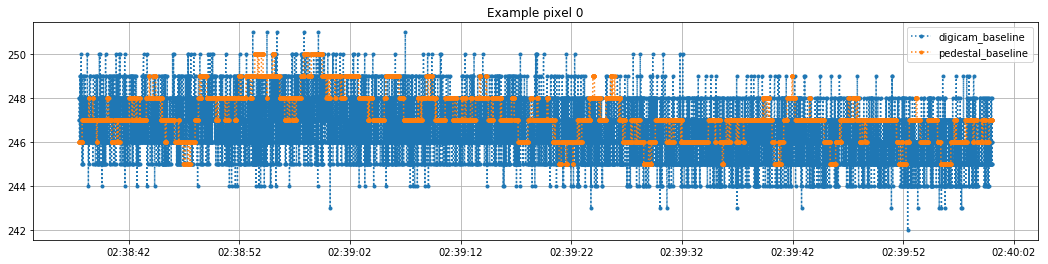

In [9]:
plt.figure(figsize=(18, 4))
plt.plot(T, digicam_baseline[:,0], '.:', label='digicam_baseline');
plt.plot(T, pedestal_baseline[:,0], '.:', label='pedestal_baseline');
plt.title('Example pixel 0');
plt.legend()
plt.grid()


In [10]:
diff = digicam_baseline - pedestal_baseline
diff[:, Broken] = 0

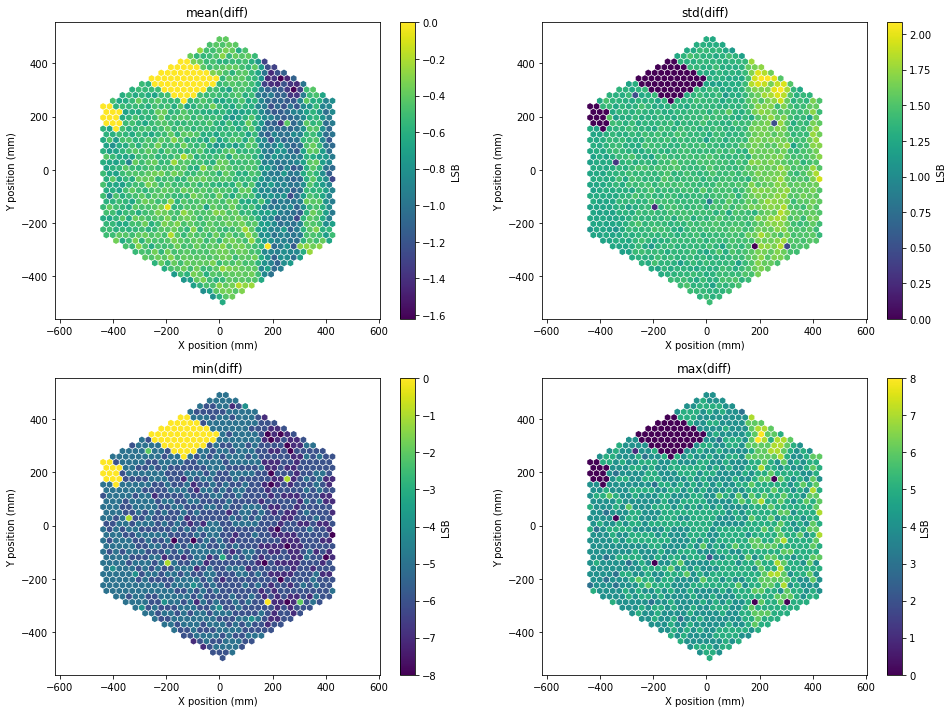

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

camera(diff.mean(axis=0), ax=ax[0, 0], title='mean(diff)')
camera(diff.std(axis=0), ax=ax[0, 1], title='std(diff)')
camera(diff.min(axis=0), ax=ax[1, 0], title='min(diff)')
camera(diff.max(axis=0), ax=ax[1, 1], title='max(diff)');

We see the mean difference is less than -1LSB. Ignoring the known broken pixels, we see a vertical bar in the camera where the two different baseline implementations do not agree very well. Let us have a look at another run...

Using run: ../data/SST1M01_20171030.035.fits.fz


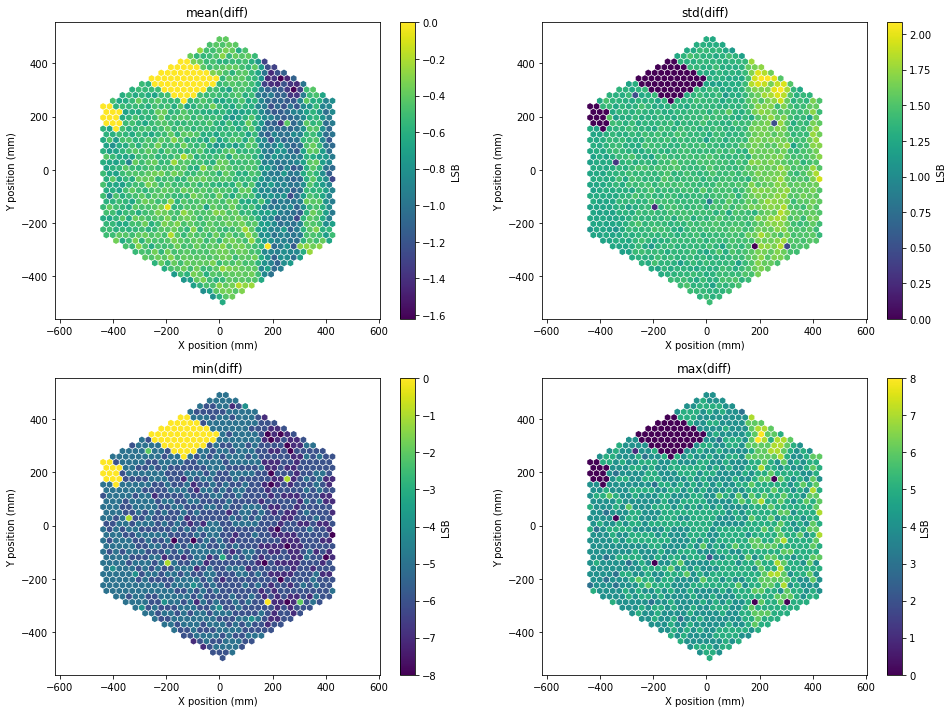

In [12]:
path = paths[35]
print('Using run:', path)
digicam_baseline = []
pedestal_baseline = []
T = []
stream = event_stream(example_path)
stream = fill_baseline_r0(stream, n_bins=1050) # <--- n_bins=1050 from nsb_evaluation.py default of 10k ... 
for event in stream:
    for r0 in event.r0.tel.values():
        digicam_baseline.append(r0.digicam_baseline)
        pedestal_baseline.append(r0.baseline)
        T.append(r0.local_camera_clock)
        
pedestal_baseline = np.array(pedestal_baseline)
digicam_baseline = np.array(digicam_baseline)
T = pd.to_datetime(T, unit='ns')

# At run-start we have not enough statistics, so at the beginning there is sometimes no pedestal_baseline
# So we drop that
missing_data = np.isnan(pedestal_baseline).any(axis=1)
pedestal_baseline = pedestal_baseline[~missing_data]
digicam_baseline = digicam_baseline[~missing_data]
T = T[~missing_data]

# digicam_baseline is an integer, pedestal_baseline is a float. For easier comparision I 
# round pedestal_baseline to the next integer
pedestal_baseline = pedestal_baseline.round().astype(np.int16)

diff = digicam_baseline - pedestal_baseline
diff[:, Broken] = 0

fig, ax = plt.subplots(2, 2, figsize=(16, 12))

camera(diff.mean(axis=0), ax=ax[0, 0], title='mean(diff)')
camera(diff.std(axis=0), ax=ax[0, 1], title='std(diff)')
camera(diff.min(axis=0), ax=ax[1, 0], title='min(diff)')
camera(diff.max(axis=0), ax=ax[1, 1], title='max(diff)');

We see a very similar vertical bar or stripe in the camera. Maybe a shadow from the structure... but since it is visible in at least two runs, let us have a look at the worst pixels and see whats going on.

I want to have a look at the 4 worst pixels, that means, the pixels in the upper right part, and below I look at 4 typical pixels for comparison.

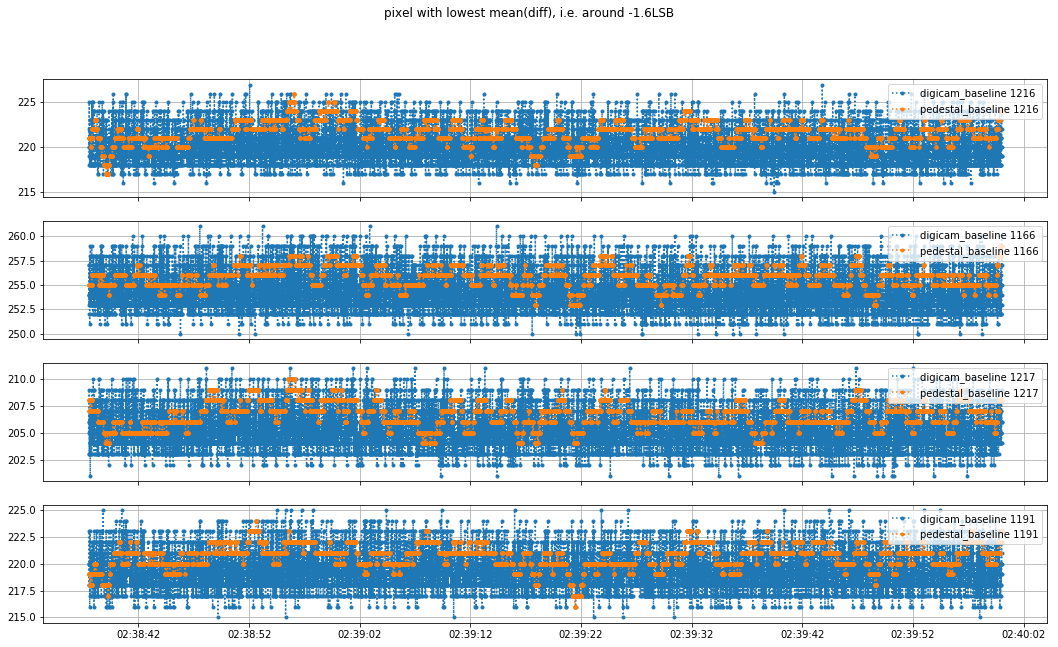

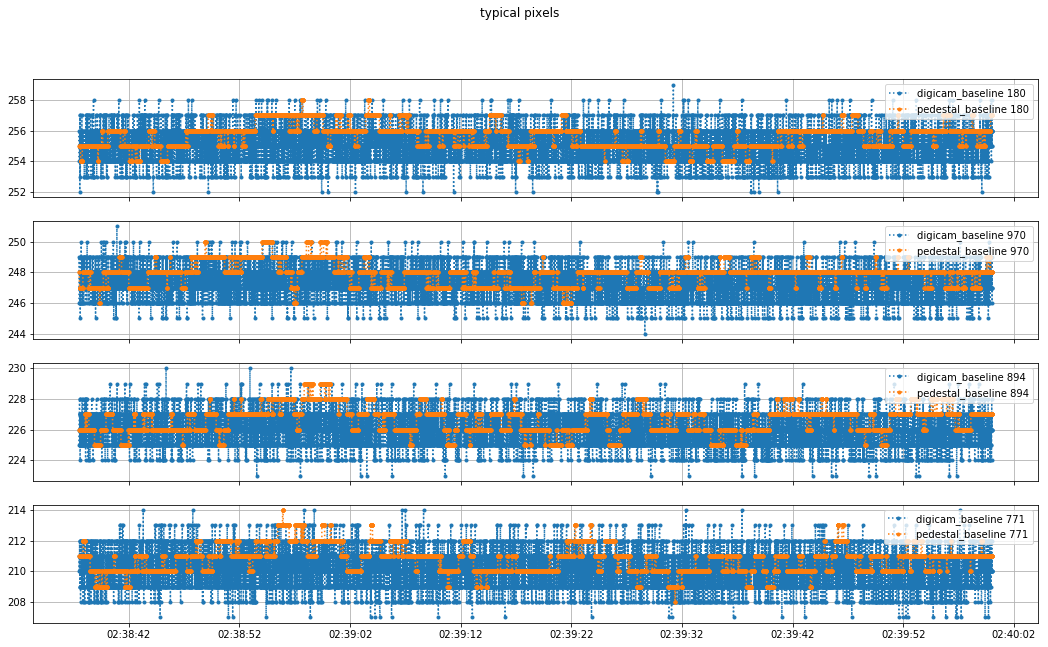

In [13]:
worst_pixels = np.argsort(diff.mean(axis=0))[:4]

fig, ax = plt.subplots(4, figsize=(18, 10), sharex=True)
plt.suptitle('pixel with lowest mean(diff), i.e. around -1.6LSB')
for i, pix in enumerate(worst_pixels):
    ax[i].plot(T, digicam_baseline[:,pix], '.:', label='digicam_baseline '+str(pix));
    ax[i].plot(T, pedestal_baseline[:,pix], '.:', label='pedestal_baseline '+str(pix));
    ax[i].legend(loc='upper right')
    ax[i].grid()
    
typical = np.argsort(diff.mean(axis=0))[500:504]
fig, ax = plt.subplots(4, figsize=(18, 10), sharex=True)
plt.suptitle('typical pixels')
for i, pix in enumerate(typical):
    ax[i].plot(T, digicam_baseline[:,pix], '.:', label='digicam_baseline '+str(pix));
    ax[i].plot(T, pedestal_baseline[:,pix], '.:', label='pedestal_baseline '+str(pix));
    ax[i].legend(loc='upper right')
    ax[i].grid()
    


By eye, it looks to me like the orange pedestal baseline does not behave much different in the "worst pixels" compared to "typical pixels". But I see that the blue digicam baseline is much more noisy in the "worst pixels". 

A noisy baseline might be a sign for really noisy illumination conditions, or it may be a sign for a problem with the sensor itself. I don't know. However, the plots below show that the width of the `digicam_baseline` shows the same vertical bar as we have seen also in the difference of both of the baselines.

I do not know if this behaviours is known already and I also do not know which of the two baselines is more correct. However an increase in baseline noise, might come from an increase in illumination, but I see no increase in the mean values which would support that hypothesis. 

So does this mean the `pedestal_baseline` is in fact a more reliable baseline, simply because its std-deviation looks more  homogeneous in the camera? I don't know.

In [14]:
digicam_baseline[:, Broken] = 0
pedestal_baseline[:, Broken] = 0

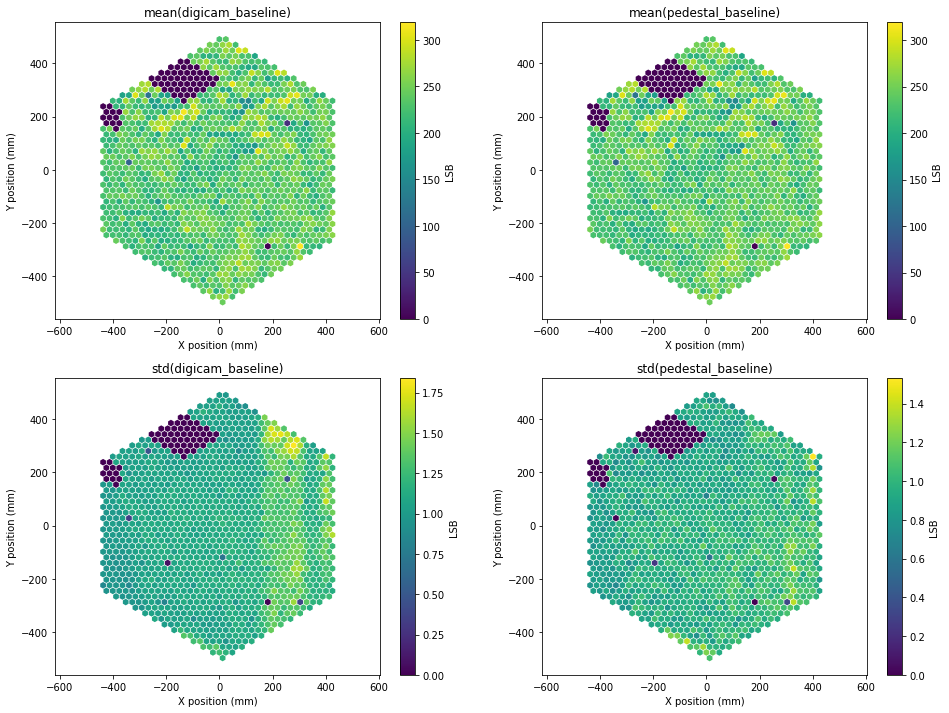

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

camera(digicam_baseline.mean(axis=0), ax=ax[0, 0], title='mean(digicam_baseline)')
camera(pedestal_baseline.mean(axis=0), ax=ax[0, 1], title='mean(pedestal_baseline)')
camera(digicam_baseline.std(axis=0), ax=ax[1, 0], title='std(digicam_baseline)')
camera(pedestal_baseline.std(axis=0), ax=ax[1, 1], title='std(pedestal_baseline)');